In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
from matplotlib import font_manager , rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# !pip install pymysql
# 여기서 pip install 하면 requirements에 포함되는지??

In [3]:
user = 'root'
pwd = '1234'
server = 'localhost'
db_name = 'movie_review'
engine = create_engine(f'mysql+pymysql://{user}:{pwd}@{server}/{db_name}?charset=utf8', convert_unicode=True)

connect = engine.connect()

raw_data = pd.read_sql_table('raw_file',connect)
raw_data

,id,user,title,genre,score
0,6,tnen,기방도령,코미디,4
1,7,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,8,tnen,사바하,미스터리,10
3,9,tnen,글래스,드라마,10
4,10,tnen,모털 엔진,액션,10
...,...,...,...,...,...
7061,7067,phs3,쓰리 빌보드,드라마,7
7062,7068,phs3,토르: 천둥의 신,판타지,3
7063,7069,1432,어벤져스: 인피니티 워,액션,10
7064,7070,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10


In [4]:
%%time
# 10개 평가 이하 영화 제거

def refinding_df(raw_data):
    title_number_df = raw_data.groupby('title').count().sort_values('user')
#     print(title_number_df)
    title_under_10 = title_number_df[title_number_df.user <= 10]
#     print(title_under_10)
    title_under_10_list = list(title_under_10)
    
    for title in title_under_10_list:
        raw_data = raw_data[raw_data['title'] != title]
    return raw_data
    
raw_df = refinding_df(raw_data)
raw_df.shape

Wall time: 26 ms


(7066, 5)

In [5]:
df = raw_df.copy()
df.tail(2)

,id,user,title,genre,score
7064,7070,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10
7065,7071,1432,위대한 쇼맨,드라마,1


In [6]:
df = df.drop(['id'], axis =1)
df

,user,title,genre,score
0,tnen,기방도령,코미디,4
1,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,tnen,사바하,미스터리,10
3,tnen,글래스,드라마,10
4,tnen,모털 엔진,액션,10
...,...,...,...,...
7061,phs3,쓰리 빌보드,드라마,7
7062,phs3,토르: 천둥의 신,판타지,3
7063,1432,어벤져스: 인피니티 워,액션,10
7064,1432,신비한 동물들과 그린델왈드의 범죄,드라마,10


###  DATA 탐색

In [7]:
user_num = df.user.unique().shape[0]
movie_num = df.title.unique().shape[0]
print(f'유저의 수는 {user_num} 명이고, \n영화의 수는 {movie_num}이다')

유저의 수는 171 명이고, 
영화의 수는 2278이다


### 평점을 많이 남긴 유저 탑10

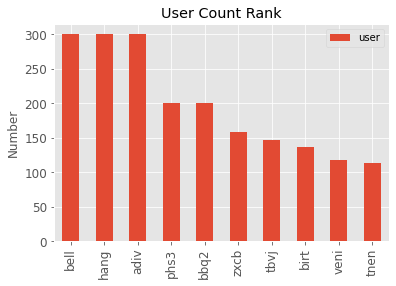

In [8]:
user_top_10 = df.user.value_counts()[:10]
plt.style.use('ggplot')
user_top_10.plot(kind='bar',title = 'User Count Rank', legend = True, fontsize='12')
plt.ylabel("Number")
plt.show()

### 유저들로 부터 평점을 많이 받은 영화 탑10

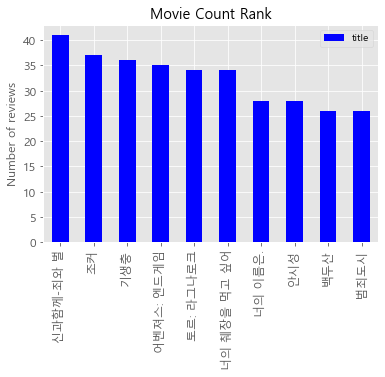

In [9]:
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
# font_name
rc('font', family = font_name)
movie_top_10 = df.title.value_counts()[:10]
movie_top_10.plot(kind='bar', title='Movie Count Rank', legend=True, fontsize=12, color='b')
plt.ylabel('Number of reviews', fontsize=12)
plt.show()
# df.title.value_counts()[:10]

### 평점 랭킹

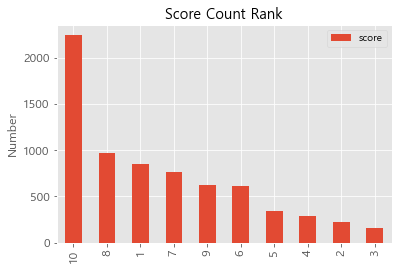

In [10]:
# df.score.value_counts()

score_ranking = df.score.value_counts()[:10]
plt.style.use('ggplot')
score_ranking.plot(kind='bar', title = 'Score Count Rank', legend = True, fontsize='12')
plt.ylabel("Number")
plt.show()

#### Colaborative Filtering
###### 1. 행렬로 만든다.
###### 2. 추천하고자 하는 유저가 입력되면 코사인 유사도를 이용하여 각 유사를 구한다.
###### 3. 추천하고자 하는 유저와 K명의 비슷한 유저들의 아이템에 대한 평점을 이용하여 t가 아직 평가하지 않은 영화의 평점을 예측해서 유저에게 추천한다.
###### 4. Validation 한다.

In [11]:
# LabelEncoder를 이용하여 수치화
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    labeling_data = Lec.fit_transform(df_copy[column_name].values)
    df_label = pd.DataFrame(labeling_data, columns=[column_name+"_label"], index=df_copy.index)
#     print(labeling_data)
    return df_label
df_user = execute_labeling('user')
df_title = execute_labeling('title')

print(len(df_user['user_label'].value_counts()))
print(len(df_title['title_label'].value_counts()))

df_copy = df.copy()
df_copy = df_copy.drop(df_copy.columns[[0,1]], axis = 1)
df_label = pd.concat([df_user, df_title, df_copy], axis = 1)
df_label.tail(5)

171
2278


,user_label,title_label,genre,score
7061,112,1251,드라마,7
7062,112,2013,판타지,3
7063,1,1370,액션,10
7064,1,1223,드라마,10
7065,1,1587,드라마,1


In [12]:
movie_list = list(df['title'].unique())
movie_list = sorted(movie_list, key = str)
movie_list
df_matrix = pd.DataFrame(columns=['user'] +movie_list)
df_matrix

,user,#살아있다,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 언리미티드,007 카지노 로얄,100 피트,...,흐르는 강물처럼,흑기사 중세로 가다,흥부: 글로 세상을 바꾼 자,희생부활자,히든 페이스,히든 피겨스,히말라야,히트맨,힐빌리의 노래,"힘을 내요, 미스터 리"


In [13]:
user_num = len(df_label.user_label.unique())
movie_num = len(df_label.title_label.unique())

user_score_list = []
for num in range(0,user_num):
    user_score_list = [0 for i in range(movie_num)]
#     print(user_score_list)
    
    df_tmp = df_label[df_label['user_label'] == num]
    for j in df_tmp.index:
        user_score_list[df_tmp.loc[j]['title_label']-1] = df_tmp.loc[j]['score']
    df_matrix.loc[num]= [num] + user_score_list
# user_score_list

type(df_matrix)

pandas.core.frame.DataFrame

In [14]:
df_matrix

,user,#살아있다,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 언리미티드,007 카지노 로얄,100 피트,...,흐르는 강물처럼,흑기사 중세로 가다,흥부: 글로 세상을 바꾼 자,희생부활자,히든 페이스,히든 피겨스,히말라야,히트맨,힐빌리의 노래,"힘을 내요, 미스터 리"
0,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,166,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167,167,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,168,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### pickle를 사용 데이터프레임을 바이너리로 바꾼다.(유틸리티 행렬)

In [15]:
import pickle
file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory)
directory.close()

In [16]:
user_name = list(df['user'].unique())
user_name = sorted(user_name, key = str)
user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']
file_user = user_name

directory_user = open('user_name', 'wb')
pickle.dump(file_user, directory_user)
directory_user.close()

In [17]:
f = open('utilitymatrix','rb')
utilitymatrix = pickle.load(f)
df = utilitymatrix
type(df)

pandas.core.frame.DataFrame

In [18]:
f = open('user_name','rb')
user_name = pickle.load(f)
user_name.tail(5)

,user_name
166,yhzz
167,yty5
168,yunh
169,zxcb
170,zzza


In [19]:
df_concat = pd.concat([user_name, df], axis = 1)
df_concat

,user_name,user,#살아있다,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 언리미티드,007 카지노 로얄,...,흐르는 강물처럼,흑기사 중세로 가다,흥부: 글로 세상을 바꾼 자,희생부활자,히든 페이스,히든 피겨스,히말라야,히트맨,힐빌리의 노래,"힘을 내요, 미스터 리"
0,0106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1432,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abcd,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,adiv,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,akfw,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,yhzz,166,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167,yty5,167,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,yunh,168,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,zxcb,169,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# 코사인 유사도를 구하는 함수를 만들어 사용
def cosine_similiarity(data_name):
    from sklearn.metrics.pairwise import cosine_distances
    similiarity = 1 - cosine_distances(data_name)
    return similiarity

cos_sim = cosine_similiarity(df)
cos_sim

array([[1.        , 0.02427281, 0.01134481, ..., 0.00718974, 0.0280878 ,
        0.        ],
       [0.02427281, 1.        , 0.00514178, ..., 0.06843035, 0.06676748,
        0.06962522],
       [0.01134481, 0.00514178, 1.        , ..., 0.0727667 , 0.08904361,
        0.08592782],
       ...,
       [0.00718974, 0.06843035, 0.0727667 , ..., 1.        , 0.92584775,
        0.9624245 ],
       [0.0280878 , 0.06676748, 0.08904361, ..., 0.92584775, 1.        ,
        0.93903741],
       [0.        , 0.06962522, 0.08592782, ..., 0.9624245 , 0.93903741,
        1.        ]])

##### 한 유저 k가 선택되면 k가 평점을 안한 영화의 평점을 예측해서 k에게 높은 것을 추천한다.
##### 다른 유저를 n명의 s 유저를 이용해서

In [30]:
class Basic(object):
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
    """유저의 이름이 들어오면 유저 번호로 변환"""
    def convert_user_num(self):
        user_name_list = list(df_concat['user_name'].unique())
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
        return user_num
    """target 유저와 유사한 유저 K명을 찾고, cosine 유사도를 이용하여 거리를 구한다"""
    def find_near_neighbor(self):
        from sklearn.neighbors import NearestNeighbors
        user_num = Basic.convert_user_num(self)
        KNN = NearestNeighbors(n_neighbors = self.neigh_num, metric = 'cosine')    # n_neighbors에는 본인이 포함되기 때문에 +1을 해준다.
        KNN.fit(df)    # data set은 utility matrix인 df를 사용
        similar_distance, similar_users = KNN.kneighbors(df)
        similars = {}    #유사한 유저와 거리를 dict형식으로 저장
        # 유사한 유저
        similar_users = similar_users[user_num][1:]
        similars['sim_users'] = list(similar_users)
        # 유사한 유저들과의 거리
        similar_distance = similar_distance[user_num][1:]
        similars['sim_distance'] = similar_distance
        return similars
    """target유저 + 유사한 유저 K명으로 이루어진 새로운 data frame 형성하고, narray 형식으로 반환"""
    def near_neighbors_narray(self):
        similars = Basic.find_near_neighbor(self)
        similiar_users_list = similars['sim_users']
        similiar_distances = similars['sim_distance']
        columns = list(df.columns)
        new_df = pd.DataFrame(columns = columns)
        for i in range(len(similiar_users_list)):
            def concat_row(i):
                neighbor_df = df[df['user'] == similiar_users_list[i]]
                return neighbor_df
            neighbor_df = pd.concat([new_df, concat_row(i)])
            new_df = neighbor_df
        narray = new_df.values
        narray = narray[:, 1:]
        return narray
            

In [31]:
user_neighbors = Basic('zzza', 20)
user_neighbors_narray = user_neighbors.near_neighbors_narray()
len(user_neighbors_narray)

19

In [34]:
class Calculation_rating(Basic):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
    """가중평균 값으로 아이템에 대한 target 유저의 평점을 예측"""
    def predict_rating(self):
        narray = Basic.near_neighbors_narray(self)    #narray 받음
        similars = Basic.find_near_neighbor(self)
        similiar_distances = similars['sim_distance']
        rating_list = []    # 가중평균값을 담는 리스트
        # 범위 0 ~ K-1
        for col_num in range(narray.shape[1]):
            sum = 0
            rating = 0
            for i in range(1, len(narray[:, col_num])):
                 sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
            rating = sum/similiar_distances.sum()
            if rating < 0:
                rating = 0    # 만약 가중평균값이 0보다 작으면 0점으로 함
            elif rating > 10:
                rating = 10    # 만약 가중평균값이 10보다 크면 10점으로 함
            else:
                rating = int(rating)    # 평점은 정수형
            rating_list.append(rating)
        return rating_list
    """target 유저의 평점을 리스트로 변환하는 함수"""
    def original_rating(self):
        user_num = Basic.convert_user_num(self)
        # target 유저의 평점을 narray로 변환
        target_df = df[df['user'] == user_num]
        target_narray = target_df.values
        target_narray = target_narray[:, 1:]    # user column 삭제
        #narray로 변환된 target 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
        return target_user_rating_list

In [35]:
user_tnen = Calculation_rating('tnen', 6)
print(user_tnen)
user_tnen.predict_rating()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
